### Environment Setup

#### Install Requirements

In [25]:
# Step 1: Check your CUDA version
%system nvcc --version

['nvcc: NVIDIA (R) Cuda compiler driver',
 'Copyright (c) 2005-2025 NVIDIA Corporation',
 'Built on Wed_Aug_20_01:58:59_PM_PDT_2025',
 'Cuda compilation tools, release 13.0, V13.0.88',
 'Build cuda_13.0.r13.0/compiler.36424714_0']

In [44]:
# Step 2: Set the line below according to your CUDA version (see https://pytorch.org/get-started/locally/)
%pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 --index-url https://download.pytorch.org/whl/cu130

# These packages are independent of CUDA version
%pip install ipywidgets kagglehub scikit-learn matplotlib seaborn

Looking in indexes: https://download.pytorch.org/whl/cu130
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]
Note: you may need to restart the kernel to use updated packages.


#### Import Libraries

In [80]:
# Standard library
import os
import random
import time
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torch.multiprocessing as mp
try:
    mp.set_start_method("fork", force=True)
except RuntimeError:
    pass

# Torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import (
    resnet50,
    ResNet50_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights,
    efficientnet_b3,
    EfficientNet_B3_Weights,
)

# Scikit-learn
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

# Kaggle
import kagglehub

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns

#### Configuration

In [52]:
# Training
VAL_RATIO = 0.15
DROPOUT = 0.3
WEIGHT_DECAY = 5e-5
BATCH_SIZE = 256
EVAL_BATCH_SIZE = BATCH_SIZE
CHECKPOINT_DIR = "checkpoints"
BACKBONE_NAME = "efficientnet_b3"  # "resnet50" or "efficientnet_b0" or "efficientnet_b3"
WARMUP_EPOCHS = 3
FINETUNE_EPOCHS = 50
LR_HEAD = 5e-4
LR_BACKBONE = 1e-4
PATIENCE = 10
MIN_DELTA = 1e-4
USE_FOCAL_LOSS = False
LABEL_SMOOTHING = 0.0

# Dataset
DATASET = "hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images"
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")
CLASSES = ["benign", "malignant"]
IMG_SIZE = 300
WORKERS = 4
PREFETCH = 4
PIN_MEMORY = True
PERSISTENT_WORKERS = True

# ImageNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
AMP_DTYPE = torch.float16
USE_AMP = True

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
torch.device(DEVICE)
print("Using device:", DEVICE)

if torch.cuda.is_available():
    torch.cuda.set_device(2)
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    AMP_DTYPE = torch.bfloat16
    
# Random number generation
SEED = 42
random.seed(SEED)
GENERATOR = torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Using device: cuda
Using GPU: NVIDIA H100 PCIe


### Prepare Dataset

#### Download from Kaggle

In [29]:
# You need a Kaggle account and an API token to download datasets.
# https://www.kaggle.com/docs/api#authentication

if "KAGGLE_USERNAME" not in os.environ:
    os.environ["KAGGLE_USERNAME"] = input("Kaggle Username")
    
if "KAGGLE_API_TOKEN" not in os.environ:
    os.environ["KAGGLE_API_TOKEN"] = input("Kaggle API Token")
os.environ["KAGGLE_KEY"] = os.environ["KAGGLE_API_TOKEN"]

DATASET_ROOT = kagglehub.dataset_download(DATASET)
DATASET_ROOT = f"{DATASET_ROOT}/melanoma_cancer_dataset"
print(DATASET_ROOT)

TRAIN_ROOT = f"{DATASET_ROOT}/train"
assert os.path.isdir(TRAIN_ROOT)

TEST_ROOT = f"{DATASET_ROOT}/test"
assert os.path.isdir(TEST_ROOT)

# Validate class directories
for split in [TRAIN_ROOT, TEST_ROOT]:
    for cls in CLASSES:
        path = os.path.join(split, cls)
        assert os.path.isdir(path), f"Directory not found: {path}"

/u50/clubinew/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset


#### Define Transformations

In [30]:
train_transform = T.Compose(
    [
        T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),

        T.AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET),
        
        # geometric augmentations
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomRotation(degrees=10, fill=0),
        T.RandomApply(
            [
                T.RandomPerspective(distortion_scale=0.05, p=1.0),
                T.RandomAffine(
                    degrees=0,
                    translate=(0.05, 0.05),
                    scale=(0.95, 1.05),
                    shear=5,
                    fill=0,
                ),
            ],
            p=0.3,
        ),

        # lighting augmentations
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
        T.RandomApply([T.RandomAdjustSharpness(sharpness_factor=1.5)], p=0.2),
        T.RandomApply([T.RandomAutocontrast()], p=0.2),
        T.RandomApply([T.RandomEqualize()], p=0.1),

        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        T.RandomErasing(p=0.15, value="random"),
    ]
)

eval_transform = T.Compose(
    [
        T.Resize(IMG_SIZE),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)


#### Create Datasets and DataLoaders

In [31]:
def validate_image(filename):
    return filename.lower().endswith(VALID_EXTENSIONS)

# The full training dataset will be split into separate training and validation sets
val_full = ImageFolder(TRAIN_ROOT, transform=eval_transform, is_valid_file=validate_image)
train_full = ImageFolder(TRAIN_ROOT, transform=train_transform, is_valid_file=validate_image)
shuffled_indices = torch.randperm(len(train_full), generator=GENERATOR).tolist()

# Validation set
val_size = int(len(val_full) * VAL_RATIO)
val_indices = shuffled_indices[:val_size]
val_ds = Subset(val_full, val_indices)
val_loader = DataLoader(
    val_ds,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    prefetch_factor=PREFETCH,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS
)
print(f"Loaded {len(val_ds)} validation samples")

# Training set
train_size = len(train_full) - val_size
train_indices = shuffled_indices[val_size:]
train_ds = Subset(train_full, train_indices)
# Weighted sampler to balance classes
targets = torch.tensor([train_full.targets[i] for i in train_indices])
class_count = torch.bincount(targets)
class_weight = 1.0 / (class_count.float() + 1e-6)
sample_weights = class_weight[targets]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    num_workers=WORKERS, 
    prefetch_factor=PREFETCH, 
    pin_memory=PIN_MEMORY, 
    persistent_workers=PERSISTENT_WORKERS, 
    generator=GENERATOR,
    shuffle=False, 
)
print(f"Loaded {len(train_ds)} training samples")

# Test set
test_ds = ImageFolder(TEST_ROOT, transform=eval_transform, is_valid_file=validate_image)
test_loader = DataLoader(
    test_ds,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    prefetch_factor=PREFETCH,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS
)
print(f"Loaded {len(test_ds)} test samples")

# Validate classes
assert train_full.classes == CLASSES
assert val_full.classes == CLASSES
assert test_ds.classes == CLASSES

Loaded 1440 validation samples
Loaded 8165 training samples
Loaded 1000 test samples


### Training Setup

#### Parameter Freezing

In [ ]:
def get_head_param_prefix(backbone_name: str):
    if backbone_name == "resnet50":
        return "fc."
    elif backbone_name in ["efficientnet_b0", "efficientnet_b3"]:
        return "classifier.1."
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")


def freeze_backbone(model: nn.Module, backbone_name: str):
    head_param_prefix = get_head_param_prefix(backbone_name)
    for n, p in model.named_parameters():
        p.requires_grad = n.startswith(head_param_prefix)
    return model


def unfreeze_backbone(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = True
    return model

#### Model

In [ ]:
def build_model(
    backbone_name,
    num_classes,
    frozen=True
):
    if backbone_name == "resnet50":
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif backbone_name == "efficientnet_b0":
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(nn.Dropout(p=DROPOUT), nn.Linear(in_features, num_classes))
    elif backbone_name == "efficientnet_b3":
        model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(nn.Dropout(p=DROPOUT), nn.Linear(in_features, num_classes))
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

    if frozen:
        freeze_backbone(model, backbone_name)

    return model

#### Optimizer

In [ ]:
def make_optimizer(model, lr_head, lr_backbone, backbone_name):
    # separate head and backbone parameters
    head_params, bb_params = [], []
    head_param_prefix = get_head_param_prefix(backbone_name)
    for n, p in model.named_parameters():
        # skip frozen parameters
        if not p.requires_grad:
            continue
        if n.startswith(head_param_prefix):
            head_params.append(p)
        else:
            bb_params.append(p)

    return torch.optim.AdamW(
        [
            {"params": bb_params, "lr": lr_backbone},
            {"params": head_params, "lr": lr_head},
        ],
        weight_decay=WEIGHT_DECAY,
    )

#### Criterion

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, logits, targets):
        logpt = F.log_softmax(logits, dim=1)
        pt = torch.exp(logpt.gather(1, targets.view(-1,1))).squeeze()
        ce = self.ce(logits, targets)
        return ((1 - pt) ** self.gamma * ce).mean()

#### Checkpointing

In [35]:
if not os.path.isdir(CHECKPOINT_DIR):
    Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

def save_best_checkpoint(path, model, optimizer, epoch, best_auc, classes, backbone_name):
    payload = {
        "epoch": epoch,
        "best_roc_auc": best_auc,
        "backbone": backbone_name,
        "classes": classes,
        "model_id": f"{backbone_name}-{int(time.time())}",
        "state_dict": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    }
    torch.save(payload, path)


def restore_checkpoint(path, model, optimizer):
    assert os.path.exists(path), f"Checkpoint path does not exist: {path}"
    payload = torch.load(path, map_location=DEVICE)
    model.load_state_dict(payload["state_dict"])
    optimizer.load_state_dict(payload["optimizer_state"])
    print(f"Restored model and optimizer from checkpoint: {path}")
    return payload

#### Evaluation

In [36]:
def find_best_threshold_for_accuracy(y_true_np, y_prob_np):
    # y_true_np should be 0/1 for negative/positive
    thresholds = np.linspace(0.0, 1.0, 1001)
    best_thr, best_acc = 0.5, 0.0
    for t in thresholds:
        y_hat = (y_prob_np >= t).astype(int)
        acc = (y_hat == y_true_np).mean()
        if acc > best_acc:
            best_acc, best_thr = acc, t
    return float(best_thr), float(best_acc)


def compute_metrics(y_true, y_prob):
    pos_idx = CLASSES.index("malignant")
    metrics = {}

    try:
        metrics["roc_auc"] = float(roc_auc_score(y_true == pos_idx, y_prob))
    except:
        metrics["roc_auc"] = float("nan")
    metrics["pr_auc"] = float(average_precision_score(y_true == pos_idx, y_prob))

    y_hat = (y_prob >= 0.5).astype(int)
    metrics["f1"] = float(f1_score(y_true == pos_idx, y_hat, zero_division=0))
    metrics["precision"] = float(precision_score(y_true == pos_idx, y_hat, zero_division=0))
    metrics["recall"] = float(recall_score(y_true == pos_idx, y_hat, zero_division=0))
    metrics["accuracy"] = float(accuracy_score(y_true == pos_idx, y_hat))

    cm = confusion_matrix(y_true == pos_idx, y_hat, labels=[0, 1])
    metrics["confusion_matrix"] = cm.tolist()
    
    return metrics


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    pos_idx = CLASSES.index("malignant")

    y_true, y_prob_list = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        probs = F.softmax(logits, dim=1)
        y_prob = probs[:, pos_idx]
        y_true.append(yb.detach().cpu())
        y_prob_list.append(y_prob.detach().cpu())

    y_true = torch.cat(y_true).numpy()
    y_prob = torch.cat(y_prob_list).numpy()

    return y_true, y_prob


@torch.no_grad()
def evaluate_with_tta(model, loader):
    model.eval()
    pos_idx = CLASSES.index("malignant")

    def _tta_batch(x):
        t_list = [
            x,                                              # original
            torch.flip(x, dims=[-1]),                      # hflip
            torch.flip(x, dims=[-2]),                      # vflip
            torch.flip(torch.flip(x, dims=[-1]), dims=[-2]),  # hvflip
            torch.rot90(x, 1, dims=[-2, -1]),              # 90
            torch.rot90(x, 2, dims=[-2, -1]),              # 180
            torch.rot90(x, 3, dims=[-2, -1]),              # 270
        ]
        probs = []
        for xb_t in t_list:
            logits = model(xb_t)
            probs.append(F.softmax(logits, dim=1))
        return torch.stack(probs, dim=0).mean(dim=0)

    y_true, y_prob_list = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        probs_avg = _tta_batch(xb)
        y_prob = probs_avg[:, pos_idx]
        y_true.append(yb.cpu())
        y_prob_list.append(y_prob.cpu())

    y_true = torch.cat(y_true).numpy()
    y_prob = torch.cat(y_prob_list).numpy()

    return y_true, y_prob

#### Training Schedule

In [37]:
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    total, correct, running_loss = 0, 0, 0.0

    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
                logits = model(xb)
                loss = criterion(logits, yb)
        else:
            logits = model(xb)
            loss = criterion(logits, yb)

        if USE_AMP and scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return running_loss / max(total, 1), correct / max(total, 1)


def run_training(model, criterion, optimizer, scheduler, scaler, epochs, checkpoint_path, best_auc = float("-inf")):
    epoch_metrics = []
    no_improve = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
        scheduler.step()

        y_true, y_prob = evaluate(model, val_loader)
        metrics = compute_metrics(y_true, y_prob)
        metrics["train_accuracy"] = train_acc
        metrics["train_loss"] = train_loss
        epoch_metrics.append(metrics)

        print(
            f"[Epoch {epoch}/{epochs}]"
            f"\n\t[Train] "
            f"loss={train_loss:.4f} acc={train_acc:.4f}"
            f"\n\t[Val] "
            f"roc_auc={metrics['roc_auc']:.4f} pr_auc={metrics['pr_auc']:.4f} f1={metrics['f1']:.4f} acc={metrics['accuracy']:.4f}"
        )

        if metrics["roc_auc"] > best_auc + MIN_DELTA:
            best_auc = metrics["roc_auc"]
            save_best_checkpoint(checkpoint_path, model, optimizer, epoch, best_auc, CLASSES, BACKBONE_NAME)
            no_improve = 0
            print(f"\t↳ New best ROC-AUC {best_auc:.4f} — saved: {checkpoint_path}")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping after epoch {epoch}: no improvement for {no_improve} epochs.")
                break

    return epoch_metrics

### Model Training

#### Warmup

In [ ]:
model = build_model(BACKBONE_NAME, len(CLASSES)).to(DEVICE)
criterion = FocalLoss() if USE_FOCAL_LOSS else nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
scaler = torch.amp.GradScaler("cuda", enabled=(USE_AMP and torch.cuda.is_available() and AMP_DTYPE == torch.float16))
optimizer = make_optimizer(model, lr_head=LR_HEAD, lr_backbone=0, backbone_name=BACKBONE_NAME)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=WARMUP_EPOCHS)

warmup_checkpoint_path = os.path.join(CHECKPOINT_DIR, "warmup.pth")
warmup_metrics = run_training(
    model,
    criterion,
    optimizer,
    scheduler,
    scaler,
    WARMUP_EPOCHS,
    warmup_checkpoint_path
)

[Epoch 1/3]
	[Train] loss=0.5920 acc=0.7199
	[Val] roc_auc=0.9438 pr_auc=0.9422 f1=0.8754 acc=0.8806
	↳ New best ROC-AUC 0.9438 — saved: checkpoints/warmup.pth
[Epoch 2/3]
	[Train] loss=0.4783 acc=0.8091
	[Val] roc_auc=0.9476 pr_auc=0.9464 f1=0.8733 acc=0.8771
	↳ New best ROC-AUC 0.9476 — saved: checkpoints/warmup.pth
[Epoch 3/3]
	[Train] loss=0.4364 acc=0.8323
	[Val] roc_auc=0.9488 pr_auc=0.9473 f1=0.8742 acc=0.8771
	↳ New best ROC-AUC 0.9488 — saved: checkpoints/warmup.pth


#### Finetuning

In [ ]:
# restore the best checkpoint from warmup
freeze_backbone(model, BACKBONE_NAME)
optimizer = make_optimizer(model, lr_head=LR_HEAD, lr_backbone=0, backbone_name=BACKBONE_NAME)
warmup_checkpoint = restore_checkpoint(warmup_checkpoint_path, model, optimizer)

# reconfigure model/scheduler for finetuning
unfreeze_backbone(model)
optimizer = make_optimizer(model, lr_head=LR_HEAD, lr_backbone=LR_BACKBONE, backbone_name=BACKBONE_NAME)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINETUNE_EPOCHS)

finetune_checkpoint_path = os.path.join(CHECKPOINT_DIR, "finetune.pth")
finetuning_metrics = run_training(
    model,
    criterion,
    optimizer,
    scheduler,
    scaler,
    FINETUNE_EPOCHS,
    finetune_checkpoint_path,
    best_auc=warmup_checkpoint["best_roc_auc"]
)

# restore the best checkpoint from finetuning to use as our final model
finetune_checkpoint = restore_checkpoint(finetune_checkpoint_path, model, optimizer)

Restored model and optimizer from checkpoint: checkpoints/warmup.pth
[Epoch 1/50]
	[Train] loss=0.3218 acc=0.8677
	[Val] roc_auc=0.9710 pr_auc=0.9722 f1=0.9104 acc=0.9139
	↳ New best ROC-AUC 0.9710 — saved: checkpoints/finetune.pth
[Epoch 2/50]
	[Train] loss=0.2666 acc=0.8855
	[Val] roc_auc=0.9746 pr_auc=0.9759 f1=0.9152 acc=0.9187
	↳ New best ROC-AUC 0.9746 — saved: checkpoints/finetune.pth
[Epoch 3/50]
	[Train] loss=0.2291 acc=0.9032
	[Val] roc_auc=0.9738 pr_auc=0.9756 f1=0.9164 acc=0.9215


Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib64/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib64/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


[Epoch 4/50]
	[Train] loss=0.2203 acc=0.9113
	[Val] roc_auc=0.9753 pr_auc=0.9770 f1=0.9214 acc=0.9257
	↳ New best ROC-AUC 0.9753 — saved: checkpoints/finetune.pth
[Epoch 5/50]
	[Train] loss=0.1927 acc=0.9235
	[Val] roc_auc=0.9783 pr_auc=0.9801 f1=0.9323 acc=0.9361
	↳ New best ROC-AUC 0.9783 — saved: checkpoints/finetune.pth
[Epoch 6/50]
	[Train] loss=0.1883 acc=0.9249
	[Val] roc_auc=0.9798 pr_auc=0.9817 f1=0.9342 acc=0.9389
	↳ New best ROC-AUC 0.9798 — saved: checkpoints/finetune.pth
[Epoch 7/50]
	[Train] loss=0.1931 acc=0.9222
	[Val] roc_auc=0.9793 pr_auc=0.9812 f1=0.9350 acc=0.9396
[Epoch 8/50]
	[Train] loss=0.1764 acc=0.9336
	[Val] roc_auc=0.9808 pr_auc=0.9826 f1=0.9393 acc=0.9431
	↳ New best ROC-AUC 0.9808 — saved: checkpoints/finetune.pth
[Epoch 9/50]
	[Train] loss=0.1839 acc=0.9274
	[Val] roc_auc=0.9811 pr_auc=0.9831 f1=0.9373 acc=0.9410
	↳ New best ROC-AUC 0.9811 — saved: checkpoints/finetune.pth
[Epoch 10/50]
	[Train] loss=0.1546 acc=0.9378
	[Val] roc_auc=0.9813 pr_auc=0.9833 f

### Reporting

#### Baseline Metrics

In [59]:
def print_metrics(title, y_true, y_prob):
    metrics = compute_metrics(y_true, y_prob)
    print(f"{title} Metrics:")
    for k, v in metrics.items():
        if k == "confusion_matrix":
            print(f"\t{k}: {v}")
        else:
            print(f"\t{k}: {v:.4f}")

y_true_val, y_prob_val = evaluate(model, val_loader)
print_metrics("Validation", y_true_val, y_prob_val)

y_true_test, y_prob_test = evaluate(model, test_loader)
print_metrics("Test", y_true_test, y_prob_test)

full_metrics = []
full_metrics.extend(warmup_metrics)
full_metrics.extend(finetuning_metrics)

Validation Metrics:
	roc_auc: 0.9849
	pr_auc: 0.9864
	f1: 0.9412
	precision: 0.9600
	recall: 0.9231
	accuracy: 0.9458
	confusion_matrix: [[738, 26], [52, 624]]
Test Metrics:
	roc_auc: 0.9816
	pr_auc: 0.9845
	f1: 0.9299
	precision: 0.9596
	recall: 0.9020
	accuracy: 0.9320
	confusion_matrix: [[481, 19], [49, 451]]


#### Test-Time Augmentation (TTA) Metrics

In [60]:
tta_true_val, tta_prob_val = evaluate_with_tta(model, val_loader)
print_metrics("Validation (TTA)", tta_true_val, tta_prob_val)

tta_true_test, tta_prob_test = evaluate_with_tta(model, test_loader)
print_metrics("Test (TTA)", tta_true_test, tta_prob_test)

Validation (TTA) Metrics:
	roc_auc: 0.9836
	pr_auc: 0.9857
	f1: 0.9460
	precision: 0.9590
	recall: 0.9334
	accuracy: 0.9500
	confusion_matrix: [[737, 27], [45, 631]]
Test (TTA) Metrics:
	roc_auc: 0.9789
	pr_auc: 0.9829
	f1: 0.9322
	precision: 0.9578
	recall: 0.9080
	accuracy: 0.9340
	confusion_matrix: [[480, 20], [46, 454]]


#### Tuned Accuracy

In [61]:
# Tune threshold on validation probabilities
pos_idx = CLASSES.index("malignant")
thr, val_acc = find_best_threshold_for_accuracy(
    (tta_true_val == pos_idx).astype(int),
    tta_prob_val
)
print(f"Tuned threshold: {thr:.3f}")
print(f"Tuned validation accuracy: {val_acc:.4f}")

# Evaluate on test using tuned threshold
y_hat_test = (tta_prob_test >= thr).astype(int)
test_acc = accuracy_score((tta_true_test == pos_idx).astype(int), y_hat_test)
print(f"Tuned test accuracy: {test_acc:.4f}")

Tuned threshold: 0.591
Tuned validation accuracy: 0.9549
Tuned test accuracy: 0.9330


#### Confusion Matrix

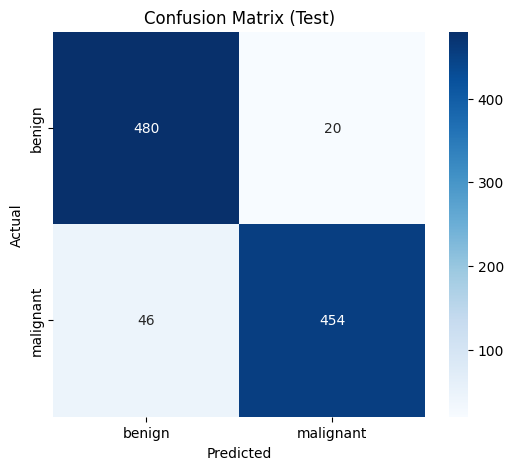

In [62]:
test_metrics = compute_metrics(tta_true_test, tta_prob_test)
plt.figure(figsize=(6, 5))
sns.heatmap(test_metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues", xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test)")
plt.show()

#### Training Progression

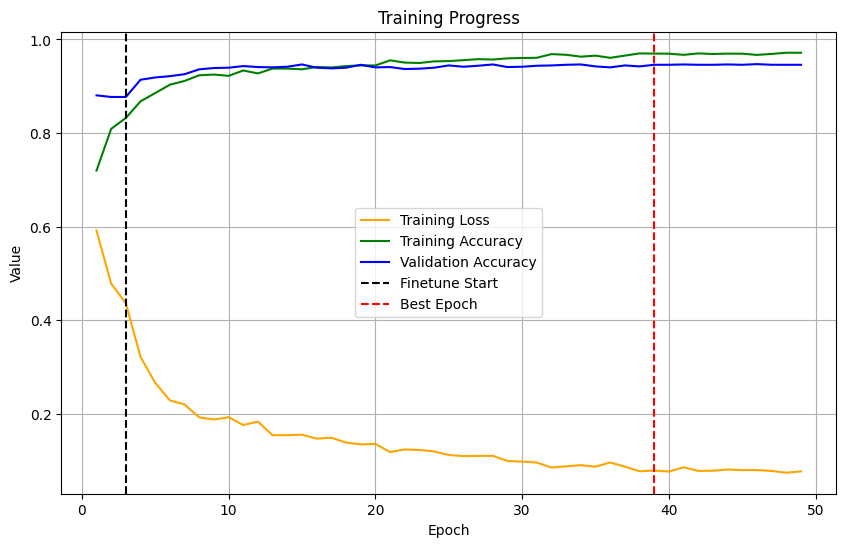

In [74]:
best_epoch = WARMUP_EPOCHS + finetune_checkpoint["epoch"]
train_losses = [m["train_loss"] for m in full_metrics]
train_accuracies = [m["train_accuracy"] for m in full_metrics]
val_accuracies = [m["accuracy"] for m in full_metrics]
epochs = list(range(1, len(full_metrics) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", color="orange")
plt.plot(epochs, train_accuracies, label="Training Accuracy", color="green")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="blue")
plt.axvline(x=WARMUP_EPOCHS, color="black", linestyle="--", label="Finetune Start")
plt.axvline(x=best_epoch, color="red", linestyle="--", label="Best Epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()

#### Validation Metrics

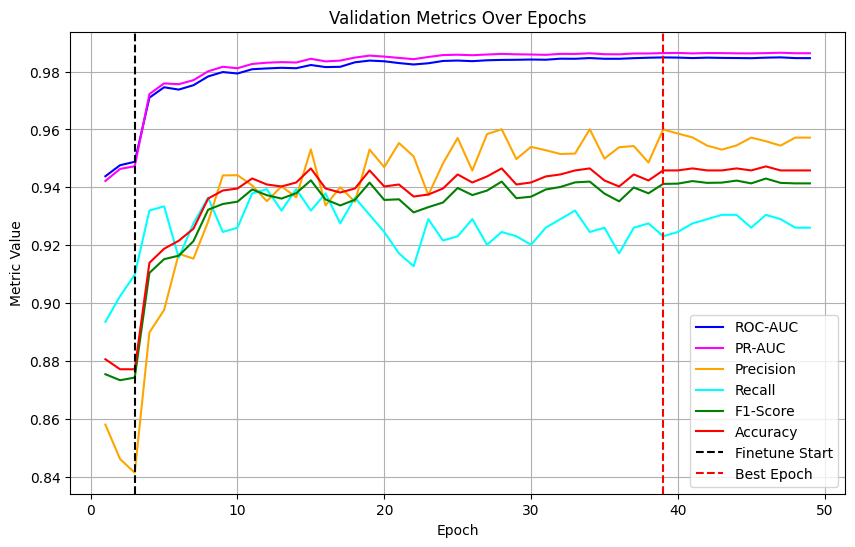

In [ ]:
roc_aucs = [m["roc_auc"] for m in full_metrics]
pr_auc = [m["pr_auc"] for m in full_metrics]
precision = [m["precision"] for m in full_metrics]
recall = [m["recall"] for m in full_metrics]
f1_scores = [m["f1"] for m in full_metrics]
accuracies = [m["accuracy"] for m in full_metrics]
plt.figure(figsize=(10, 6))
plt.plot(epochs, roc_aucs, label="ROC-AUC", color="blue")
plt.plot(epochs, pr_auc, label="PR-AUC", color="magenta")
plt.plot(epochs, precision, label="Precision", color="orange")
plt.plot(epochs, recall, label="Recall", color="cyan")
plt.plot(epochs, f1_scores, label="F1-Score", color="green")
plt.plot(epochs, accuracies, label="Accuracy", color="red")
plt.axvline(x=WARMUP_EPOCHS, color="black", linestyle="--", label="Finetune Start")
plt.axvline(x=best_epoch, color="red", linestyle="--", label="Best Epoch")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics Over Epochs")
plt.legend()
plt.grid()
plt.show()

#### Precision-Recall Curve

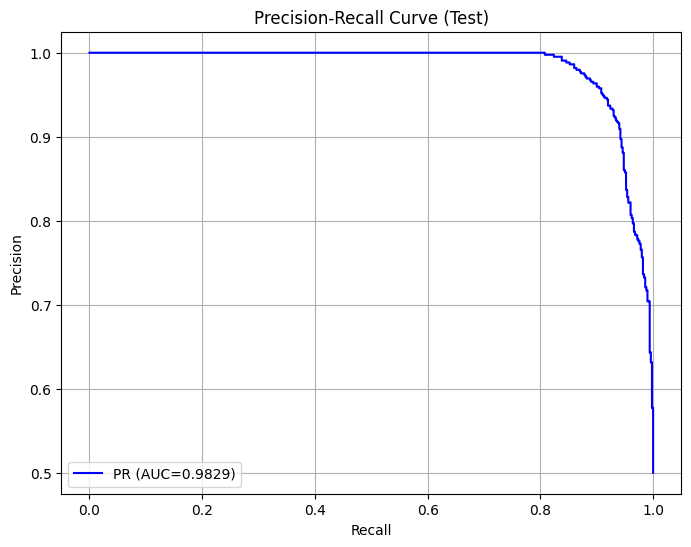

In [79]:
precision, recall, _ = precision_recall_curve(
    (tta_true_test == pos_idx).astype(int),
    tta_prob_test
)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", label=f"PR (AUC={test_metrics['pr_auc']:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.grid()
plt.show()

#### ROC Curve

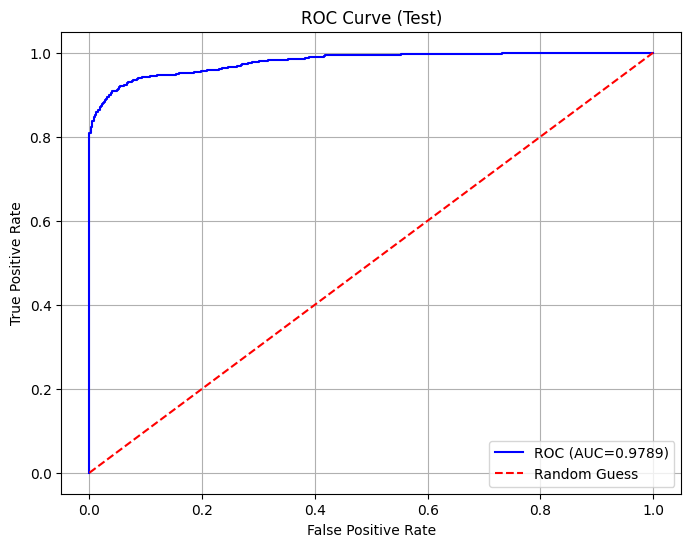

In [81]:
fpr, tpr, _ = roc_curve(
    (tta_true_test == pos_idx).astype(int),
    tta_prob_test
)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC (AUC={test_metrics['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.grid()
plt.show()